In [186]:
%cd /home/transaction-generation

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from pathlib import Path
from ebes.pipeline.utils import optuna_df
from optuna.trial import TrialState
from glob import glob
from itertools import product
import warnings
import optuna
from optuna.exceptions import ExperimentalWarning 

warnings.filterwarnings("ignore", category=ExperimentalWarning)

/home/transaction-generation


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning:

using dhist requires you to install the `pickleshare` library.



In [187]:
def get_run(path, number, dataset, method, token_mode=False, rewrite=False):
    path = Path(f"log/generation/{path}/{number}")
    save_path = Path(f"configs/best_params/{dataset}")
    if token_mode:
        save_path /= "1to1"
    save_path.mkdir(parents=True, exist_ok=True)
    save_path = save_path / f"{method}.yaml"
    if not rewrite:
        if save_path.exists():
            print("Cant rewrite")
            return
    m_d = {
        "gru": "gru, 1to1",
        "gpt": "gpt, 1to1",
        "gru_dist": "oneshot/gru, methods/oneshot/dist, allto1",
        "gru_target": "oneshot/gru, methods/oneshot/target, allto1",
        "gru_matched": "oneshot/gru, methods/oneshot/matched, allto1",
        "vae": "vae",
    }
    config = (path / "params.txt").read_text()
    print_best_res(path)
    method_part = m_d.get(method, method)
    factory = f"config_factory: [start, metrics/default, datasets/{dataset}/{dataset}, methods/{method_part}]\n\n"
    config = factory + config
    save_path.write_text(config)

def print_best_res(path):
    df = pd.read_csv(path / "results.csv", index_col=0)["mean"]
    index = [id for id in df.index if "test" in id]
    df = df.loc[index]
    df.index = [id.replace("test_", "") for id in df.index]
    df.astype(str).replace('\\.', ',', regex=True).to_csv('res', sep='\t')


def prepare_data(path):
    path = Path(f"log/generation/{path}")
    df, study = optuna_df(path)
    col_to_drop = [
        "datetime_start",
        "datetime_complete",
        "system_attrs_fixed_params",
        "state",
        "value",
    ]
    col_params = ["value", "duration"] + [col for col in df if "params_" in col]
    col_user = ["value", "duration"] + [col for col in df if "user" in col]
    # df["duration"] = df["duration"].dt.total_seconds()
    return df, study, col_user, col_params


k = -1

In [201]:
datasets = ["alphabattle_small", "age"]
methods = ["vae", "detpp"]
token_modes = [False, True]
k += 1
full_product = list(product(datasets, methods, token_modes))
dataset, method, token_mode = full_product[k % len(full_product)]

path = f"{dataset}/{'1to1/optuna' if token_mode else 'optuna'}/{method}"
print(path)
df, study, col_user, col_params = prepare_data(path)

print(df.shape, df[~df["value"].isna()].shape)
test_cols = [col for col in col_user if ("mean" in col) and ("test" in col)]
# test_cols = [col for col in test_cols if ("F1" in col) or ("Cardinality" in col)]
# par = [col for col in col_user + col_params if "BetaScheduler" in col]
# test_loss = "user_attrs_test_loss_mean"
sorted_df = df[~df["value"].isna()].sort_values("value")
best_run = sorted_df.iloc[-1].name
sorted_df[["value"] + test_cols][-10:]

age/optuna/detpp
(600, 76) (39, 76)


,value,user_attrs_test_Cardinality on small_group gen_mean,user_attrs_test_Cardinality on small_group orig_mean,user_attrs_test_F1_macro on small_group_mean,user_attrs_test_F1_micro on small_group_mean,user_attrs_test_OTD age_mean,user_attrs_test_OTD amount_rur_mean,user_attrs_test_OTD overall_mean,user_attrs_test_OTD small_group_mean,user_attrs_test_OTD trans_date_mean,user_attrs_test_loss_mean
323,-53.801930,8.407623,10.690744,0.406684,0.709420,1.000000,0.492247,0.744860,0.674824,0.812369,-53.824256
521,-53.698955,8.311434,10.690744,0.401617,0.704395,1.000000,0.490385,0.461559,0.665404,-0.309553,-53.682820
303,-53.578084,8.597641,10.690744,0.407043,0.706392,1.000000,0.481126,0.117820,0.671614,-1.681458,-53.588864
424,-53.486892,8.310889,10.690744,0.406239,0.705223,1.000000,0.485713,-0.729117,0.672663,-5.074844,-53.504483
305,-53.364592,8.392377,10.690744,0.405764,0.707696,1.000000,0.484996,0.630991,0.670208,0.368762,-53.400021
243,-53.298817,8.048276,10.690744,0.399616,0.702711,0.999983,0.484576,0.177320,0.666946,-1.442225,-53.308555
199,-53.010165,8.415971,10.690744,0.406165,0.707475,1.000000,0.494215,0.210566,0.672465,-1.324415,-52.983262
215,-52.730473,8.462069,10.690744,0.412511,0.711451,1.000000,0.492488,0.344957,0.674467,-0.787126,-52.751526
536,-52.546022,8.453721,10.690744,0.412231,0.711927,1.000000,0.493737,0.212641,0.675386,-1.318558,-52.566565
282,-52.479327,8.415971,10.690744,0.409260,0.710158,1.000000,0.492007,-0.551265,0.674943,-4.372010,-52.496105


In [153]:
get_run(path, 183, dataset, method, token_mode, True)


In [116]:
sorted_df[[col for col in col_user if ("memory" in col)]][-10:]

,user_attrs_memory_after_mean,user_attrs_memory_after_std
74,11054.0,0.0
50,15448.0,0.0
66,17772.0,0.0
49,18908.0,0.0
78,11762.0,0.0
42,17686.0,0.0
82,14168.0,0.0
81,11378.0,0.0
80,11174.0,0.0
84,12696.0,0.0


In [202]:
failed = df[(df["state"] != "COMPLETE") | (df[col_user].isna().any(axis=1))][col_user].index
print(failed)
for fail in df[(df["state"] != "COMPLETE") | (df[col_user].isna().any(axis=1))][col_user].index:
    error_path = Path(f"log/generation/{path}/{fail}/ERROR.txt")
    if error_path.exists():
        error = error_path.read_text()
        print(fail, error.split("\n")[-2])
    else:
        print(fail, df.loc[fail])

Index([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,
       ...
       590, 591, 592, 593, 594, 595, 596, 597, 598, 599],
      dtype='int64', length=561)
0 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 10.74 GiB. GPU 
2 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 23.06 GiB. GPU 
3 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 34.15 GiB. GPU 
4 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 26.54 GiB. GPU 
5 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 23.06 GiB. GPU 
6 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 19.27 GiB. GPU 
7 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 25.91 GiB. GPU 
8 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 17.69 GiB. GPU 
9 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 11.38 GiB. GPU 
10 torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 16.43 

In [203]:
# optuna.visualization.plot_optimization_history(study)

### Params influence

In [208]:
trials = study.trials
trials = [trial for trial in trials if (trial.state == TrialState.COMPLETE) and (trial.user_attrs["test_OTD overall_mean"] >= 0)]
plotted_trials = sorted(trials, key=lambda t: t.value)[-50:]
study = optuna.create_study()

for trial in plotted_trials:
    study.add_trial(trial)

[I 2025-09-17 16:32:25,349] A new study created in memory with name: no-name-e32c7dc9-77d3-4f89-a81e-fd82a1f1a16d


In [209]:
target = lambda t: (t.user_attrs["test_OTD overall_mean"])
target_name = "target"
fig = optuna.visualization.plot_param_importances(study, target=target, target_name=target_name)
print(fig._data[0]["x"][::-1])
print(fig._data[0]["y"][::-1])
take = 7
params = fig._data[0]["y"][-take:]
not_imp = list(set([col.replace("params_", "") for col in col_params]) - set(params) - {"duration", "value", "system_attrs_fixed_params"})
fig

[0.23141008578310748, 0.16500716421245565, 0.15059980400575643, 0.1390501909275202, 0.10177335445367579, 0.0744818241233398, 0.06174244431668359, 0.04290175182182384, 0.03232785756333466, 0.0007055227923024105]
['optimizer.params.weight_decay', 'model.latent_encoder.params.hidden_size', 'optimizer.params.lr', 'loss.params.matching_weights._presence', 'model.autoencoder.params.cat_emb_dim', 'model.latent_encoder.params.num_layers', 'model.params.k_factor', 'model.autoencoder.params.num_norm', 'model.autoencoder.params.num_emb_dim', 'model.latent_encoder.params.dropout']


In [210]:
params

['model.params.k_factor',
 'model.latent_encoder.params.num_layers',
 'model.autoencoder.params.cat_emb_dim',
 'loss.params.matching_weights._presence',
 'optimizer.params.lr',
 'model.latent_encoder.params.hidden_size',
 'optimizer.params.weight_decay']

In [211]:
# fig = optuna.visualization.plot_parallel_coordinate(plotted_study, target=target, target_name=target_name, params=['model.encoder.params.pooling', 'pretrain_model.encoder.params.pooling',])
# fig = optuna.visualization.plot_contour(study, target=target, target_name=target_name, params=params+not_imp)
fig = optuna.visualization.plot_slice(study, target=target, target_name=target_name)#, params=["model.encoder.params.num_layers"] )
# fig = optuna.visualization.plot_optimization_history(study, target=target, target_name=target_name, error_bar=False)
# targets = lambda t: (t.params["schedulers.beta.BetaScheduler.factor"], t.user_attrs["test_Reconstruction overall_mean"])
# target_names = ["memory_after_mean", "test_Reconstruction overall_mean"]
# fig = optuna.visualization.plot_pareto_front(study, targets=targets, target_names=target_names)
fig

In [197]:
pareto_targets = lambda t: (t.user_attrs["test_loss_mean"], t.user_attrs["test_OTD overall_mean"])
optuna.visualization.plot_pareto_front(study, targets=pareto_targets, target_names=["loss", "metric"])


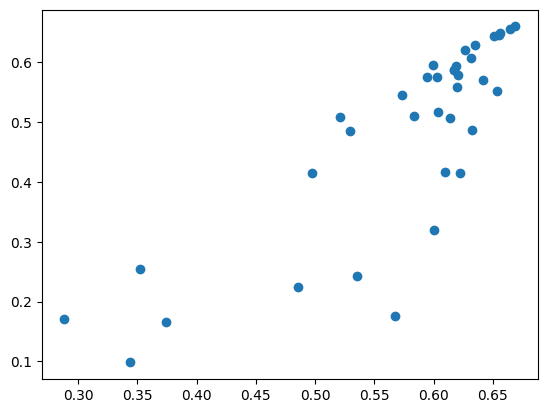

In [21]:
df[col_user]
# user_attrs_Reconstruction overall_mean
# user_attrs_test_Reconstruction overall_mean  
corr = df.loc[:, ["user_attrs_Reconstruction overall_mean", "user_attrs_test_Reconstruction overall_mean"]].values
corr = corr[corr[:, 1] > 0.]
corr = corr.T
plt.scatter(corr[0], corr[1])

In [14]:
corr[1]

array([ 2.24765981e-01,  5.58193365e-01,  5.79441426e-01, -2.52478756e+01,
       -1.83249119e+00,  5.93541510e-01, -6.89742099e+01,  6.20540413e-01,
        5.51473175e-01,  5.75338017e-01,  5.87397511e-01,  5.06810327e-01,
        4.14948080e-01,  6.56091304e-01, -2.29449604e+02,  6.59978799e-01,
        5.95479827e-01,  6.08065133e-01,  6.28701189e-01,  3.19842927e-01,
        6.48585040e-01,  5.70997809e-01,  4.16447689e-01, -2.43559946e+01,
       -1.92204170e-01,  4.85782606e-01,  1.76263074e-01,  2.43228096e-01,
        4.86158230e-01,  5.44850264e-01,  5.08651126e-01,  6.44586897e-01,
        6.46302449e-01,  5.16191953e-01,  5.87891203e-01,  4.15233483e-01,
        5.76327024e-01,  5.09958578e-01])

In [20]:
df.columns

Index(['value', 'datetime_start', 'datetime_complete', 'duration',
       'params_model.encoder.params.dropout',
       'params_model.encoder.params.hidden_size',
       'params_model.encoder.params.num_layers',
       'params_model.preprocessor.batch_transforms.0.TimeToFeatures.process_type',
       'params_model.preprocessor.cat_emb_dim',
       'params_model.preprocessor.num_emb_dim',
       'params_model.preprocessor.num_norm', 'params_optimizer.params.lr',
       'params_optimizer.params.weight_decay',
       'user_attrs_Reconstruction amount_mean',
       'user_attrs_Reconstruction amount_std',
       'user_attrs_Reconstruction currency_mean',
       'user_attrs_Reconstruction currency_std',
       'user_attrs_Reconstruction days_since_first_tx_mean',
       'user_attrs_Reconstruction days_since_first_tx_std',
       'user_attrs_Reconstruction dst_type11_mean',
       'user_attrs_Reconstruction dst_type11_std',
       'user_attrs_Reconstruction dst_type12_mean',
       'user_attr